##### %load_ext autoreload
%autoreload 2

In [48]:
import torch
import mediapy as media
import torch.optim as optim
from einops import rearrange
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
# from model import RecurrentConvNLayer
from model import RecurrentOneLayer

from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
# 1) imports
import json
import torch
from torch.nn import functional as F
from main import LitDenoiser, MNISTDataModule, ImageDataModule  # assumes train_denoiser.py is on your PYTHONPATH
from model import *
import numpy as np
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc


from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
def vis_patches(patches, title="", figsize=None, colorbar=False,
                      ncol=None, pad_value="min", show=True,
                      return_tensor=False, vmin=None, vmax=None, fontsize=20,
                      dpi=None, normalize = False,cmap_value =2,padding=1):
    """
    Given patches of images in the dataset, create a grid and display it.

    Parameters
    ----------
    patches : Tensor of (batch_size, pixels_per_patch) or 
        (batch_size, channels, pixels_per_patch)

    title : String; title of figure. Optional.
    """
    
    if normalize:
        # print(patches.norm(dim=[-1,-2],keepdim=True).shape)
        patches=patches-patches.mean(dim=(1,2),keepdim=True)
        # patches=patches/patches.norm(dim=[-1,-2],keepdim=True)
        p2p = patches.amax(dim=(1,2),keepdim=True)-patches.amin(dim=(1,2),keepdim=True).clamp(min=1e-8)
        patches=(patches/p2p).clamp(min=-cmap_value,max=cmap_value)
    
    if patches.dim() == 2:
        channels = 1
        patches.unsqueeze_(1)
    else:
        channels = patches.size(1)
    batch_size = patches.size(0)
    size = int(np.sqrt(patches.size(-1)))

    img_grid = []
    for i in range(batch_size):
        img = torch.reshape(patches[i], (channels, size, size))
        img_grid.append(img)

    if pad_value != 0:
        if pad_value == "min":
            pad_value = torch.min(patches)
        elif pad_value == "max":
            pad_value = torch.max(patches)

    if not ncol:
        ncol = int(np.sqrt(batch_size))
    out = make_grid(img_grid, padding=padding, nrow=ncol, pad_value=pad_value)
    # normalize between 0 and 1 for rgb
    if channels == 3:
        out = ((out - torch.min(out))/(torch.max(out) - torch.min(out))).permute(1, 2, 0)
    else:
        out = out[0]

    if show:
        plt.tick_params(axis='both', which='both', bottom=False, left=False,
                        labelbottom=False, labelleft=False)
        plt.xticks([])
        plt.yticks([])
        plt.title(title, fontsize=fontsize)
        fig = plt.gcf()
        ax = plt.gca()
        ax.set_frame_on(False)
        if figsize:
            fig.set_size_inches(figsize)
        if dpi:
            fig.set_dpi(dpi)
        if vmin is not None and vmax is not None:
            if channels != 3:
                plt.imshow(out, cmap="gray", vmin=vmin, vmax=vmax)
            else:
                plt.imshow(out, vmin=vmin, vmax=vmax)
        else:
            if channels != 3:
                plt.imshow(out, cmap="gray")
            else:
                plt.imshow(out)
        if colorbar:
            # this sometimes gets the colorbar to match height of the plot...?
            plt.colorbar(fraction=0.046, pad=0.04)

            # cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
            # cbar = fig.colorbar(cax)
            # cbar.ax.tick_params(labelsize=30) 
        plt.show()
    if return_tensor:
        return out

# ---------- helpers ----------
def _to_display01(x: torch.Tensor) -> np.ndarray:
    """x: [1 or B, C, H, W] in [-1,1] -> numpy image in [0,1]."""
    if x.ndim == 3:
        x = x.unsqueeze(0)
    x = (x + 1.0) * 0.5
    x = x.clamp(0, 1)
    x0 = x[0].detach().cpu()
    if x0.size(0) == 1:      # grayscale
        return x0.squeeze(0).numpy()
    return x0.permute(1, 2, 0).numpy()  # HWC

def _psnr_single(a: torch.Tensor, b: torch.Tensor, peak: float = 2.0) -> float:
    mse = F.mse_loss(a, b, reduction='mean').double().item()
    if mse <= 1e-12:
        return float('inf')
    return 10.0 * np.log10((peak * peak) / mse)

def _crop_numpy(img_np: np.ndarray, y0: int, x0: int, h: int, w: int) -> np.ndarray:
    return img_np[y0:y0+h, x0:x0+w] if img_np.ndim == 2 else img_np[y0:y0+h, x0:x0+w, :]

def _resolve_roi(H, W, roi=None, roi_frac=None):
    """Return integer (y0,x0,h,w) inside image bounds."""
    if roi is not None:
        y0, x0, h, w = map(int, roi)
    else:
        if roi_frac is None:
            roi_frac = (0.35, 0.45, 0.22, 0.22)  # (fy, fx, fh, fw)
        fy, fx, fh, fw = roi_frac
        y0 = int(np.clip(fy * H, 0, H-1))
        x0 = int(np.clip(fx * W, 0, W-1))
        h  = max(1, int(np.clip(fh * H, 1, H)))
        w  = max(1, int(np.clip(fw * W, 1, W)))
    y0 = np.clip(y0, 0, max(0, H-1))
    x0 = np.clip(x0, 0, max(0, W-1))
    h  = min(h, H - y0)
    w  = min(w, W - x0)
    return int(y0), int(x0), int(h), int(w)

# ---------- main: 5-panel with zoom ----------
@torch.inference_mode()
def show_denoising_with_zoom_three(
    y, net1, net2, net3, sigma_viz, peak, *,
    name_1="Net1", name_2="Net2", name_3="Net3",
    idx_img=None, idx_sigma=None,
    aug_labels=None,
    roi=None, roi_frac=None,
    inset_size=0.45,                 # fraction of axes size (0..1)
    inset_loc="upper right",
    zoom_border_color="yellow",
    seed=None,
    device = 'cuda',
    save_path = "./figures"
):
    """
    y: clean batch [B,C,H,W] in [-1,1]
    sigma_viz: scalar or 1D tensor of sigmas
    peak: dynamic range (2.0 for [-1,1])
    """
    B, C, H, W = y.shape

    # choose sample/sigma
    if idx_img is None:
        idx_img = np.random.randint(B)
    sigma_viz_cpu = torch.as_tensor(sigma_viz).detach().cpu()
    if sigma_viz_cpu.ndim == 0:
        idx_sigma = 0
        s_sel = float(sigma_viz_cpu.item())
        noisy_psnr = float(10.0 * torch.log10(peak**2 / (sigma_viz_cpu**2)).item())
    else:
        if idx_sigma is None:
            idx_sigma = np.random.randint(len(sigma_viz_cpu))
        s_sel = float(sigma_viz_cpu[idx_sigma].item())
        noisy_psnr = float(10.0 * torch.log10(peak**2 / (sigma_viz_cpu[idx_sigma]**2)).item())
    # print(y.shape)
    clean = y[idx_img:idx_img+1].to(device)
    sb1   = torch.tensor(s_sel, device=clean.device, dtype=clean.dtype).view(1,1,1,1)

    # make noisy
    if seed is not None:
        # g = torch.Generator(device=clean.device).manual_seed(int(seed))
        noisy_1img = clean + torch.randn_like(clean) * sb1
    else:
        noisy_1img = clean + torch.randn_like(clean) * sb1

    # run all three nets once
    # print(noisy_1img.shape,sb1.shape,aug_labels)
    out1 = net1(noisy_1img, noise_labels = sb1.flatten())
    out2 = net2(noisy_1img, noise_labels = sb1.flatten())
    out3 = net3(noisy_1img, noise_labels = sb1.flatten())

    # PSNRs
    psnr_noisy = noisy_psnr
    psnr_out1  = _psnr_single(out1, clean, peak=float(peak))
    psnr_out2  = _psnr_single(out2, clean, peak=float(peak))
    psnr_out3  = _psnr_single(out3, clean, peak=float(peak))

    # convert to display
    img_clean = _to_display01(clean)
    img_noisy = _to_display01(noisy_1img)
    img_out1  = _to_display01(out1)
    img_out2  = _to_display01(out2)
    img_out3  = _to_display01(out3)

    # ROI and crops
    y0, x0, h, w = _resolve_roi(H, W, roi=roi, roi_frac=roi_frac)
    crops = [
        _crop_numpy(img_clean, y0, x0, h, w),
        _crop_numpy(img_noisy, y0, x0, h, w),
        _crop_numpy(img_out1, y0, x0, h, w),
        _crop_numpy(img_out2, y0, x0, h, w),
        _crop_numpy(img_out3, y0, x0, h, w),
    ]

    titles = [
        "Clean — PSNR=∞",
        f"Noisy — PSNR={psnr_noisy:.2f} dB",
        f"{name_1} — PSNR={psnr_out1:.2f} dB",
        f"{name_2} — PSNR={psnr_out2:.2f} dB",
        f"{name_3} — PSNR={psnr_out3:.2f} dB",
    ]
    images = [img_clean, img_noisy, img_out1, img_out2, img_out3]

    # Plot 1×5
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for ax, im, crop, title in zip(axes, images, crops, titles):
        if im.ndim == 2:
            ax.imshow(im, cmap='gray')
        else:
            ax.imshow(im)
        ax.set_title(title, fontsize=10)
        ax.axis('off')

        # ROI rect
        rect = Rectangle((x0, y0), w, h, linewidth=2, edgecolor=zoom_border_color, facecolor='none')
        ax.add_patch(rect)

        # inset
        axins = inset_axes(ax, width=f"{int(inset_size*100)}%", height=f"{int(inset_size*100)}%", loc=inset_loc)
        if crop.ndim == 2:
            axins.imshow(crop, cmap='gray')
        else:
            axins.imshow(crop)
        axins.set_xticks([]); axins.set_yticks([])
        for spine in axins.spines.values():
            spine.set_edgecolor(zoom_border_color)
            spine.set_linewidth(2)
            
    # --- Save before show ---
    if save_path is not None:
        save_dir = os.path.dirname(str(save_path))
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
        fig.savefig(str(save_path), dpi=200, bbox_inches='tight', pad_inches=0.02)

    plt.tight_layout()
    plt.show()


import numpy as np
import mediapy as media

def _pad_center(video: np.ndarray, H: int, W: int, fill: float = 1.0) -> np.ndarray:
    """Pad (T,h,w) to (T,H,W) with 'fill' (white=1.0), centered."""
    T, h, w = video.shape
    if h == H and w == W:
        return video
    out = np.full((T, H, W), fill, dtype=np.float32)
    top  = (H - h) // 2
    left = (W - w) // 2
    out[:, top:top+h, left:left+w] = video
    return out

def make_side_by_side_white_many(videos, gap_px: int = 16, fill: float = 1.0):
    """
    videos: list of (T,H,W) grayscale arrays (float [-1,1] or [0,1], or uint8)
    Returns: (T, Hmax, sum_width) stitched video with white padding and white gaps.
    """
    assert isinstance(videos, (list, tuple)) and len(videos) > 0, "Provide a non-empty list of videos."

    vids = [v for v in videos ]
    # sync time
    T = min(v.shape[0] for v in vids)
    vids = [ v[:T] for v in vids ]

    # pad every clip to a common (Hmax, Wmax)
    Hmax = max(v.shape[1] for v in vids)
    Wmax = max(v.shape[2] for v in vids)
    vids = [ _pad_center(v, Hmax, Wmax, fill=fill) for v in vids ]

    # white gap
    gap = np.full((T, Hmax, gap_px), fill, dtype=np.float32) if len(vids) > 1 else None

    # interleave videos with gaps
    pieces = []
    for i, v in enumerate(vids):
        pieces.append(v)
        if gap is not None and i < len(vids) - 1:
            pieces.append(gap)

    combo = np.concatenate(pieces, axis=2)  # (T, Hmax, N*Wmax + (N-1)*gap_px)
    return combo

In [49]:
def load_net(BASE_DIR):

    # 3) load the config
    with open(f"{BASE_DIR}/config.json", "r") as f:
        config = json.load(f)
    # print(config)
    # 4) rebuild the model (Lightning will wrap it, but we just need the raw module here)
    clean_config_dict  = {
        k: config[k] for k in [
            "in_channels", "num_basis", "eta_base", "n_iters_inter", "n_iters_intra",
            "kernel_size", "stride",
            "sigma","lr",
            "ema_halflife_kimg","ema_rampup_ratio",
            "model_arch", "eta_ls", 
            "P_mean","P_std", "edm_weighting",
            "jfb_no_grad_iters","jfb_with_grad_iters","jfb_reuse_solution","jfb_ddp_safe",
            "whiten_dim","T","frequency_groups","whiten_ks","pyramid",
            "h_groups","groups","energy_function","per_dim_threshold",
            "multiscale", "constraint_energy", "intra",
            # "k_inter"
        ]
    }
    # clean_config_dict["h_groups"]=1
    # clean_config_dict["groups"]=3
    # clean_config_dict["k_inter"]=20
    
    clean_config_dict["learning_horizontal"] = not config["no_learning_horizontal"]
    clean_config_dict["stable"] = config.get("stable")
    print(clean_config_dict)
    # print(clean_config_dict)
    # clean_config_dict  = {
    #     k: config[k] for k in [
    #         "in_channels", "num_basis", "eta_base", "n_iters_inter", "n_iters_intra",
    #         "kernel_size", "stride",
    #         "sigma","lr",
    #         "ema_halflife_kimg","ema_rampup_ratio",
    #         "model_arch",
    #         "P_mean","P_std", "edm_weighting",
    #     ]
    # }
    model = LitDenoiser(**clean_config_dict)
    model.eval()  # important!
    model = model.to(device)

    # 5) load the checkpoint
    #    if you used save_weights_only=True you need to wrap it in state_dict
    ckpt_path = f"{BASE_DIR}/{config.get('best_ckpt', 'denoiser.ckpt')}"
    state = torch.load(ckpt_path, map_location="cpu")
    if "state_dict" in state:
        model.load_state_dict(state["state_dict"])
    else:
        model.load_state_dict(state)

    return config,model

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# verify the spectrum of the kernel,
# and the equivalent band pass filter

def _gauss_kernel2d(ks: int, sigma: float, device=None, dtype=None):
    """Return normalized 2D Gaussian kernel [1,1,ks,ks]."""
    ax = torch.arange(ks, device=device, dtype=dtype) - (ks - 1) / 2.0
    g1 = torch.exp(-0.5 * (ax / sigma) ** 2)
    g1 = g1 / g1.sum()
    g2 = torch.outer(g1, g1)
    g2 = g2 / g2.sum()
    return g2.view(1, 1, ks, ks)

class GaussianPyramidEncoder(nn.Module):
    """
    Multi-level Gaussian/Laplacian analysis.
    Outputs residuals r_s and final base b_L. Optionally upsamples
    everything to the input resolution and concatenates along channels.
    """
    def __init__(self, levels=2, kernel_size=5, sigma=1.2,
                 concat_to_channels=True, learnable=False, reflect_pad=True):
        super().__init__()
        assert levels >= 1
        self.levels = levels
        self.ks = int(kernel_size)
        self.sigma = float(sigma)
        self.concat = concat_to_channels
        self.reflect_pad = reflect_pad

        # Depthwise blur conv (same weights per channel)
        self.register_buffer('k2d', _gauss_kernel2d(self.ks, self.sigma))
        self.learnable = learnable
        if learnable:
            # Make kernel learnable but normalized at run time
            self.k2d_param = nn.Parameter(self.k2d.clone())
        else:
            self.k2d_param = None

    def _blur(self, x):
        B, C, H, W = x.shape
        k = self.k2d_param if self.learnable else self.k2d
        k = k.to(dtype=x.dtype, device=x.device)
        k = k.repeat(C, 1, 1, 1)  # depthwise
        pad = self.ks // 2
        if self.reflect_pad:
            x = F.pad(x, (pad, pad, pad, pad), mode='reflect')
            pad = 0
        return F.conv2d(x, k, padding=pad, groups=x.size(1))

    def forward(self, x):
        """
        x: [B, C, H, W]
        Returns:
          pyr: list [r0, r1, ..., bL] with native resolutions
          feat: [B, C*(levels+1), H, W] if concat_to_channels=True
                (order: r0, up(r1), ..., up(bL))
        """
        B, C, H, W = x.shape
        xs = x
        residuals = []
        bases = []

        # Build Gaussian pyramid bases b_1..b_L and residuals r_0..r_{L-1}
        for s in range(self.levels):
            # blur + decimate
            b_next = F.avg_pool2d(self._blur(xs), kernel_size=2, stride=2)
            # upsample back to current scale
            up_next = F.interpolate(b_next, size=xs.shape[-2:], mode='bilinear', align_corners=False)
            # Laplacian residual at this scale
            r_s = xs - up_next
            residuals.append(r_s)
            bases.append(b_next)
            xs = b_next

        bL = xs  # final base
        pyr = residuals + [bL]

        if not self.concat:
            return pyr, None

        # Upsample all to input resolution and concat along channels
        ups = []
        for r_s in residuals:
            if r_s.shape[-2:] != (H, W):
                r_s = F.interpolate(r_s, size=(H, W), mode='bilinear', align_corners=False)
            ups.append(r_s)
        bL_up = F.interpolate(bL, size=(H, W), mode='bilinear', align_corners=False)
        ups.append(bL_up)
        feat = torch.cat(ups, dim=1)  # [B, C*(levels+1), H, W]
        return feat

# Convenience wrapper matching your ask
def encoder_g_pyramid(x, levels=2, kernel_size=5, sigma=1.2, concat_to_channels=True):
    """
    Functional wrapper: returns (pyr, feat).
    pyr = [r0, r1, ..., bL]; feat is concatenated at input res if requested.
    """
    enc = GaussianPyramidEncoder(levels=levels, kernel_size=kernel_size,
                                 sigma=sigma, concat_to_channels=concat_to_channels)
    enc.eval()  # kernel is fixed; keeps behavior deterministic
    with torch.no_grad():
        return enc(x)

# pad and attempt to make needle plot
import torch

def _avg_pad_to_11(w2: torch.Tensor) -> torch.Tensor:
    """
    w2: (B, 1, 7, 7) -> (B, 1, 11, 11) with per-kernel average padding.
    """
    B, C, H, W = w2.shape
    assert (C, H, W) == (1, 7, 7)
    mean = w2.mean(dim=(-1, -2), keepdim=True)          # (B,1,1,1)
    out = mean.expand(B, 1, 11, 11).clone()              # fill with mean
    out[:, :, 2:-2, 2:-2] = w2                           # center insert
    return out

def _shift_fill(x: torch.Tensor, dy: int, dx: int, fill11: torch.Tensor) -> torch.Tensor:
    """
    Shift x by (dy, dx) inside 11x11 canvas; new areas filled with per-kernel mean.
    x:      (B,1,11,11)
    fill11: (B,1,11,11) filled with each kernel's mean value
    """
    B, C, H, W = x.shape
    out = fill11.clone()
    y0, y1 = max(0, dy), H + min(0, dy)
    x0, x1 = max(0, dx), W + min(0, dx)
    out[:, :, y0:y1, x0:x1] = x[:, :, y0 - dy:y1 - dy, x0 - dx:x1 - dx]
    return out

def pad_and_make_9_shifts(w2: torch.Tensor, shift: int = 2) -> torch.Tensor:
    """
    w2: (B,1,7,7) -> (B,9,1,11,11)
    Order of the 9 is row-major over (dy,dx) in [-shift,0,shift]:
    [(-s,-s), (-s,0), (-s,+s), (0,-s), (0,0), (0,+s), (+s,-s), (+s,0), (+s,+s)]
    """
    base11 = _avg_pad_to_11(w2)                          # (B,1,11,11)
    mean = w2.mean(dim=(-1, -2), keepdim=True)           # (B,1,1,1)
    fill11 = mean.expand_as(base11)                      # (B,1,11,11)

    shifts = [(-shift, -shift), (-shift, 0), (-shift, +shift),
              (0, -shift),      (0, 0),      (0, +shift),
              (+shift, -shift), (+shift, 0), (+shift, +shift)]
    variants = [_shift_fill(base11, dy, dx, fill11) for dy, dx in shifts]
    return torch.stack(variants, dim=1)                  # (B,9,1,11,11)

In [51]:

from scipy.optimize import curve_fit
from scipy.ndimage import rotate
from scipy.signal import hilbert

def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y


def gaussian_2d_full(coords, A, x0, y0, sigma_x, sigma_y, rho, C):
    x, y = coords
    # Covariance matrix and its inverse
    cov = np.array([[sigma_x**2, rho * sigma_x * sigma_y],
                    [rho * sigma_x * sigma_y, sigma_y**2]])
    inv_cov = np.linalg.inv(cov)
    
    # Center the coordinates
    dx = x - x0
    dy = y - y0
    exponent = -(dx * (inv_cov[0, 0] * dx + inv_cov[0, 1] * dy) +
                 dy * (inv_cov[1, 0] * dx + inv_cov[1, 1] * dy)) / 2
    return np.exp(A) * np.exp(exponent) + C

def get_basis_needle_plot(image):

    center_surround = False

    pad_width = ((50, 50), (50, 50))  # 50 pixels padding on all sides
    # print(image.min())
    padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)

    # compute the Fourier Transform
    fft_result = np.fft.fft2(padded_image)
    fft_shifted = np.fft.fftshift(fft_result)  # shift zero frequency to center
    amplitude_spectrum = np.abs(fft_shifted)   # compute the amplitude spectrum

    angles = np.linspace(0, 180, 180, endpoint=False)  # Orientations in degrees
    orientation_tuning = []

    # Step 4: Compute energy at each orientation
    for angle in angles:
        # Rotate the amplitude spectrum to align the orientation with a specific angle
        rotated_spectrum = rotate(amplitude_spectrum, angle, reshape=False, order=1)
        # Sum along the central axis to get energy for this orientation
        energy = np.sum(rotated_spectrum[amplitude_spectrum.shape[0] // 2, :])
        orientation_tuning.append(energy)

    # Step 5: Normalize the orientation tuning curve
    orientation_tuning = np.array(orientation_tuning)
    orientation_tuning /= orientation_tuning.max()  # Normalize to [0, 1]

    # if orientation_tuning.max()-orientation_tuning.min() < 0.5:
    #     center_surround = True
        
    if not center_surround:
        theta = np.pi/180*angles[np.argmax(orientation_tuning)] + np.pi/2

        # compute the envelope using gradient magnitude
        # I_x = sobel(image, axis=0)
        # I_y = sobel(image, axis=1)
        # envelope = np.sqrt(I_x**2 + I_y**2)

        analytic_signal_x = hilbert(image, axis=0)  # Transform along x-axis
        analytic_signal = hilbert(np.real(analytic_signal_x), axis=1)  # Transform along y-axis
        envelope = np.abs(analytic_signal)  # Envelope is the magnitude of the analytic signal


        # fit the Gaussian
        x = np.arange(image.shape[1])
        y = np.arange(image.shape[0])
        x, y = np.meshgrid(x, y)

        max_index = np.argmax(envelope)
        row_index = max_index // envelope.shape[1]
        col_index = max_index % envelope.shape[1]

        # Fit the data
        initial_guess = (0.1, col_index, row_index, 2, 2, 0, 0)
        bounds = (
            (-np.inf,-1,-1,-np.inf,-np.inf,-np.inf,-np.inf),
            ( np.inf,16,16, np.inf, np.inf, np.inf, np.inf),
        )
        successful_fit = True
        try:
            params, _ = curve_fit(
                gaussian_2d_full, 
                (x.ravel(), y.ravel()), 
                envelope.ravel(), 
                p0=initial_guess,
                bounds=bounds,
                maxfev=5000
            )
            # Generate fitted Gaussian for comparison
            fitted_gaussian = gaussian_2d_full((x, y), *params).reshape(x.shape)
            _, x0, y0, sigma_x, sigma_y, rho, C = params 
            

            cov_matrix = np.array([
                [sigma_x**2, rho * sigma_x * sigma_y],
                [rho * sigma_x * sigma_y, sigma_y**2]
            ])
            val,vec = np.linalg.eig(cov_matrix)
            length = 0.3*val.max()
            mean = (x0,y0)
        except RuntimeError:
            print("Least-squares minimization failed to find parameters")
            length = 0
            mean = (0,0)
            successful_fit = False

        one_extreme = polar_to_cartesian(length,theta)
        other_extreme = polar_to_cartesian(length,theta+np.pi)

    res = {}
    res["center_surround"] = center_surround
    res["sucessful_fit"]   = successful_fit
    res["theta"]           = theta
    res["length"]          = length
    res["mean"]            = mean
    if not center_surround:
        res["x"] = np.asarray([one_extreme[0],other_extreme[0]])+mean[0]
        res["y"] = np.asarray([one_extreme[1],other_extreme[1]])+mean[1]
    else:
        max_pos = np.unravel_index(np.argmax(np.abs(image)), image.shape)
        res["x"] = max_pos[1]
        res["y"] = max_pos[0]
    return res

In [52]:
device = "cuda:0"
# BASE_DIR3 = "./pretrained_model/scaling-VH-new-2/00119_layer1-SC-BM-noise-labels-zero-scratch-reuse-horizontal-groups-2-h_groups-1-pyramid-3"
# BASE_DIR3 = "./pretrained_model/scaling-VH-new-2/00157_layer1-multiscale_neural_sheet"
# BASE_DIR3 = "pretrained_model/scaling-new-face/00062_layer1-multiscale_neural_sheet"
# BASE_DIR3 = "pretrained_model/scaling-VH-new-2/00159_layer1-multiscale_neural_sheet_no_intra"

# BASE_DIR3 = "pretrained_model/scaling-new-face/00067_layer1_neural_sheet"
# BASE_DIR3 = "pretrained_model/scaling-new-face/00068_layer1_neural_sheet_intra"
# BASE_DIR3 = "pretrained_model/scaling-new-face/00069_layer1_neural_sheet"

# BASE_DIR3 = "pretrained_model/scaling-mnist-exercise/00090_layer1-multiscale_neural_sheet"
# BASE_DIR3 = "pretrained_model/scaling-mnist-exercise/00091_layer1-multiscale_neural_sheet_small"
# level 1 model 
# BASE_DIR3 = "pretrained_model/scaling-mnist-exercise/00119_layer1_neural_sheet"

# masking
# BASE_DIR3 = "pretrained_model/scaling-mnist-exercise/00100_layer1-multiscale_neural_sheet"
# BASE_DIR3 = "pretrained_model/scaling-mnist-exercise/00118_layer1-multiscale_neural_sheet_sparse/
# BASE_DIR3 = "model_banks/HC_model"

BASE_DIR3 = "model_banks/00159_layer1-multiscale_neural_sheet_no_intra/"
config,net3 = load_net(BASE_DIR3)
net_infer = net3
# 6) prepare the data
# dm = ImageDataModule(batch_size=config["batch_size"],data_dir = "/home/zeyu/celeba")
# dm = ImageDataModule(batch_size=config["batch_size"],data_dir = "/home/zeyu/vanhateren_all/vh_patches256_train")
dm = ImageDataModule(
    data_dir=config["data_dir"],
    # data_dir="/home/zeyu/data/celeba",
    batch_size=32,
    num_workers=4,
    # img_size=config["img_size"],
    img_size = 256,
    val_split=0.2,
    test_split=0.0,
    seed=42,
    grayscale=config["grayscale"],
    no_resize=config["no_resize"],
    random_crop=config["random_crop"],
)
dm.setup()  # runs prepare_data + splits
test_loader = dm.test_dataloader()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

# avg_snr = evaluate_snr(model, test_loader,device,sigma =sigma)

{'in_channels': 1, 'num_basis': [32, 32, 32], 'eta_base': 0.1, 'n_iters_inter': 3, 'n_iters_intra': 1, 'kernel_size': 7, 'stride': 2, 'sigma': [0.01, 0.5], 'lr': 0.0003, 'ema_halflife_kimg': 500.0, 'ema_rampup_ratio': 0.05, 'model_arch': 'neural_sheet', 'eta_ls': None, 'P_mean': -1.6, 'P_std': 0.7, 'edm_weighting': True, 'jfb_no_grad_iters': [1, 5], 'jfb_with_grad_iters': [1, 3], 'jfb_reuse_solution': False, 'jfb_ddp_safe': False, 'whiten_dim': None, 'T': 0.0, 'frequency_groups': None, 'whiten_ks': 3, 'pyramid': False, 'h_groups': 1, 'groups': 1, 'energy_function': 'elastic', 'per_dim_threshold': True, 'multiscale': True, 'constraint_energy': 'SC', 'intra': False, 'learning_horizontal': True, 'stable': False}
intra False
<class 'model.neural_sheet'>
intra False
EMA <class 'model.neural_sheet'>


/tmp/ipykernel_1830540/1001988827.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="cpu")


In [53]:
_ = net_infer.model(torch.randn(10,1,64,64).to(device))
sigma_viz = 0.2
n_levels = len(net_infer.model.levels)

# sb1 = torch.ones(B).to(device)*sigma_viz
B_ =5
noise_emb_ls = []
for i in range(n_levels):
    with torch.no_grad():
        sb1 = torch.linspace(0.01,0.5,B_).to(device)
        emb = net_infer.model.map_noise(sb1)                       # [B, Cn]
        emb = emb.reshape(B_, 2, -1).flip(1).reshape(B_, -1)       # swap sin/cos
        emb = F.relu(net_infer.model.map_layer0(emb))
        noise_emb = net_infer.model.affines[i](emb)
        noise_emb_ls.append(noise_emb)

In [54]:
dictionary_viz = []
for i in range(n_levels):
    phi = net_infer.model.levels[i].decoder.conv.weight.data.cpu()
    # dictionary_viz.append(phi)
    dictionary_viz.append(phi[phi.flatten(1).norm(dim=1).sort().indices])

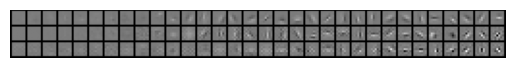

In [55]:
vis_patches(torch.cat(dictionary_viz[:]).flatten(2),ncol = 32)

In [56]:
## Let's do a per group analysis
level = 0

In [57]:
dictionary_viz = []
norms = []
for i in range(n_levels):
    phi = net_infer.model.levels[i].decoder.conv.weight.data.cpu()
    # dictionary_viz.append(phi)
    norm_ = phi.flatten(1).norm(dim=1)
    norms.append(norm_)
    dictionary_viz.append(phi)

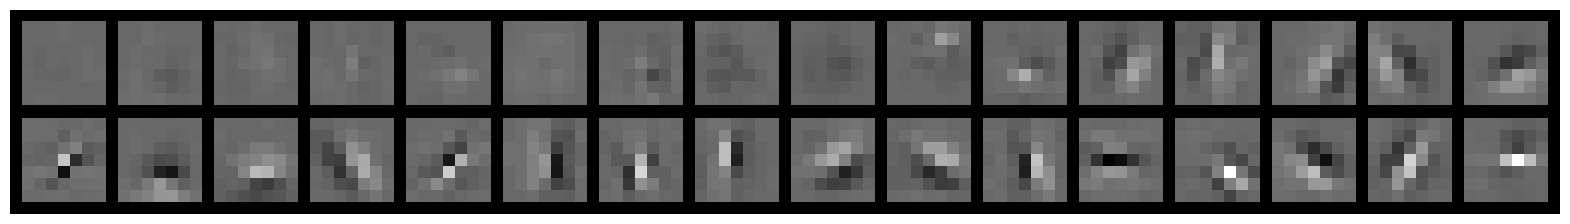

In [58]:
vis_patches(dictionary_viz[level][norms[level].sort().indices].flatten(2),ncol = 16,normalize =False,figsize = (20,4))

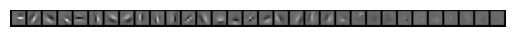

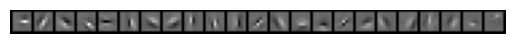

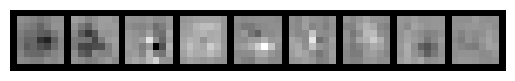

In [59]:
# sort and visualize
level = 0
k_ = 23
norm_ = norms[level]
norm_sort_val, norm_sort_idx = norm_.sort(descending =True)
bottom_phi_norm_idx = norm_sort_idx[k_:]
top_phi_norm_idx = norm_sort_idx[:k_]
threshold = norm_sort_val[k_]
vis_patches(dictionary_viz[level][norm_sort_idx].flatten(2),ncol = 32,normalize =False)
vis_patches(dictionary_viz[level][top_phi_norm_idx].flatten(2),ncol = 32,normalize =False)
vis_patches(dictionary_viz[level][bottom_phi_norm_idx].flatten(2),ncol = 32,normalize =False)

In [60]:
# dictionary_viz[level].shape

In [61]:
dictionary = dictionary_viz[level][:,0]

needle_properties = {}
for i in tqdm(range(dictionary.shape[0])):
    # print(norm_[i])
    if norm_[i]>threshold:
        try:
            needle_properties[i] = get_basis_needle_plot(dictionary[i])
        except:
            print(i)

100%|███████████████████████████████████████████| 32/32 [00:02<00:00, 11.33it/s]


# plot all dictionary that has large norm and receptive field fitted, we can see these neurons have well defined receptive field

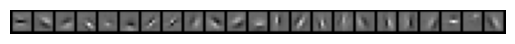

In [62]:
vis_patches(dictionary_viz[level][list(needle_properties.keys())].flatten(2),ncol = 32,normalize =False)

In [63]:
encoder = net_infer.model.levels[level].encoder
encoder.padding = (2,2)
filter_ = encoder.weight.data
with torch.no_grad():
    G =encoder(filter_).cpu()
horizontal = net_infer.model.levels[0].M_inter.weight.data.cpu()
n1,n2,h,w =horizontal.shape
horizontal_flat = rearrange(horizontal,"n1 n2 h w -> n1 (n2 h w)")
gram_flat = rearrange(G,"n1 n2 h w -> n1 (n2 h w)")
gram_flat_complement = rearrange(G,"n1 n2 h w -> n1 (n2 h w)")

In [64]:
def horizontal_field_for_unit(net_infer, level_idx, chan_idx, H=13, W=13, device='cuda'):
    """
    Returns: image field (1, H, W) showing how unit (level_idx, chan_idx)
    spreads via M_inter and then into pixel space via decoder.
    """
    lvl = net_infer.model.levels[level_idx]      # a neural_node
    decoder = lvl.decoder

    C = lvl.M_inter.weight.shape[0]    # num_basis at this level

    a = torch.zeros(1, C, H, W, device=device)
    a[0, chan_idx, H//2, W//2] = 1.0   # one hot in a-space

    with torch.no_grad():
        horiz = lvl.M_inter(a)         # apply lateral kernel
        img = decoder(horiz)           # push to image space

    # (assuming single visible channel; adjust indexing if not)
    return img[0, 0].cpu()


In [65]:
gnorm_flat = norm_.unsqueeze(1).repeat(1,9).flatten()

In [66]:
def modify(l_cor,offset,width = 1,stride = 2 ):
    return [l_cor[0]+(offset-width)*stride,l_cor[1]+(offset-width)*stride]

In [67]:
cm = 1/2
fw = 24*cm
hw = 9*cm
n_neurons=15
linewidth=1
cmap = plt.cm.Reds

In [68]:
# A.shape

In [69]:
def needle_plot_generate(connectivity_matrix, neuron_indexs, A, needle_properties, gnorm_flat, name = None, k=10):
    gnorm_flat_scale = (gnorm_flat - gnorm_flat.min())/(gnorm_flat.max()-gnorm_flat.min())
    fig,axs = plt.subplots(3,n_neurons,figsize=(fw,0.41*1.2*hw))
    # gram = adapted_gram
    for i, neuron_index in enumerate(neuron_indexs):
        ax = axs[0,i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        ax.imshow(
            A[neuron_index],
            "gray",
            origin="lower",vmin = A.min(),vmax = A.max()
            
        )
    # axs[0,0].set_ylabel("---",c="white")
    # plt.tight_layout()
    for i, neuron_index in enumerate(neuron_indexs):
        ax = axs[1,i]
        ax.set_xlim([-1,8])
        ax.set_ylim([-1,8])
        
        # topk_connected = gram[neuron_index].topk(
        topk_connected = connectivity_matrix[neuron_index].topk(k,largest=False).indices
        neuron_j, yy, xx = torch.unravel_index(topk_connected, (n2, h, w))
        topk_connected = neuron_j.tolist()
        
        for ii,connected_idx in enumerate(topk_connected):
            if connected_idx in needle_properties:
                res = needle_properties[connected_idx]
                res_x = modify(res["x"],xx[ii])
                res_y = modify(res["y"],yy[ii])
                # print(gnorm_flat_scale[connected_idx].item(),)
                ax.plot(
                    res_x,
                    res_y,
                    color=plt.cm.cividis(1.0),
                    # alpha=gnorm_flat_scale[connected_idx].item(),
                    linewidth=linewidth
                )
        if neuron_index in needle_properties:
            res = needle_properties[neuron_index]
            ax.plot(res["x"],res["y"],color="k",alpha=1,linewidth=linewidth)
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_facecolor([0.5,0.5,0.5])

    for i, neuron_index in enumerate(neuron_indexs):
        ax = axs[2,i]
        ax.set_xlim([-1,8])
        ax.set_ylim([-1,8])
        
        # topk_connected = gram[neuron_index].topk(
        topk_connected = connectivity_matrix[neuron_index].topk(k,largest=True).indices
        neuron_j, yy, xx = torch.unravel_index(topk_connected, (n2, h, w))
        topk_connected = neuron_j.tolist()
        
        for ii,connected_idx in enumerate(topk_connected):
            if connected_idx in needle_properties:
                res = needle_properties[connected_idx]
                res_x = modify(res["x"],xx[ii])
                res_y = modify(res["y"],yy[ii])
                # print(gnorm_flat_scale[connected_idx].item(),)
                ax.plot(
                    res_x,
                    res_y,
                    color=plt.cm.cividis(0.1),
                    # alpha=gnorm_flat_scale[connected_idx].item(),
                    linewidth=linewidth
                )
        if neuron_index in needle_properties:
            res = needle_properties[neuron_index]
            ax.plot(res["x"],res["y"],color="k",alpha=1,linewidth=linewidth)
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_facecolor([0.5,0.5,0.5])

    fig.suptitle("Top {} connection with {}".format(k,name))


In [70]:
# needle_properties

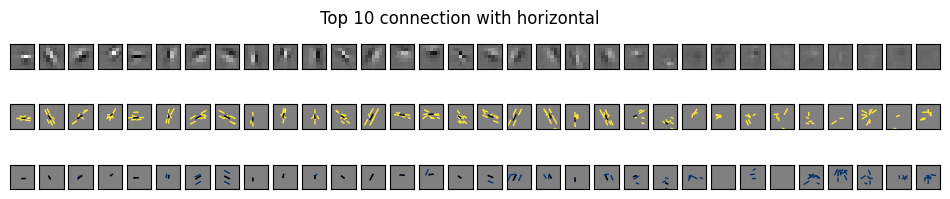

In [71]:
n_neurons=32
# connectivity_matrix = gram_all_flat_white
connectivity_matrix = horizontal_flat
# neuron_indexs = torch.arange(0,0 + n_neurons)
neuron_indexs = norm_sort_idx[:n_neurons].tolist()
A = dictionary
needle_plot_generate(connectivity_matrix, neuron_indexs, A, needle_properties, gnorm_flat, k = 10, name = "horizontal")

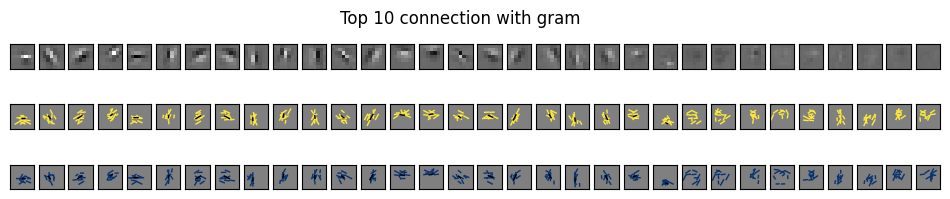

In [72]:
# connectivity_matrix = gram_all_flat_white
connectivity_matrix = gram_flat
neuron_indexs = norm_sort_idx[:n_neurons].tolist()
A = dictionary
needle_plot_generate(connectivity_matrix, neuron_indexs, A, needle_properties, gnorm_flat, k = 10, name = "gram")

In [73]:
def needle_plot_generate_strength(connectivity_matrix, neuron_indexs, A, needle_properties, gnorm_flat, k =15, name = None):
    gnorm_flat_scale = (gnorm_flat - gnorm_flat.min())/(gnorm_flat.max()-gnorm_flat.min())
    fig,axs = plt.subplots(3,n_neurons,figsize=(fw,0.41*1.2*hw))
    # gram = adapted_gram
    cmap1 = plt.cm.Reds
    cmap2 = plt.cm.Blues

    M_first_excite = connectivity_matrix.clone()
    M_first_excite[connectivity_matrix > 0] = 0
    M_first_excite = -connectivity_matrix
    # M_first_excite = (M_first_excite - M_first_excite.min())/(M_first_excite.max()-M_first_excite.min())
    
    M_first_inhib = connectivity_matrix.clone()
    M_first_inhib[connectivity_matrix < 0] = 0
    M_first_inhib = connectivity_matrix
    # M_first_inhib = (M_first_inhib - M_first_inhib.min())/(M_first_inhib.max()-M_first_inhib.min())
    
    for i, neuron_index in enumerate(neuron_indexs):
        ax = axs[0,i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        ax.imshow(
            A[neuron_index],
            "gray",
            origin="lower",vmin = A.min(),vmax = A.max()
        )
    # axs[0,0].set_ylabel("---",c="white")
    # plt.tight_layout()
    for i, neuron_index in enumerate(neuron_indexs):
        ax = axs[1,i]
        ax.set_xlim([-1,8])
        ax.set_ylim([-1,8])
        topk_connected = M_first_excite[neuron_index].topk(k,largest=True).indices
        strength_ori = M_first_excite[neuron_index,topk_connected]
        strength = (strength_ori - strength_ori.min())/(strength_ori.max()-strength_ori.min())
        neuron_j, yy, xx = torch.unravel_index(topk_connected, (n2, h, w))
        topk_connected = neuron_j.tolist()
        # print(connectivity_matrix.shape)
        # 5).indices
        # if connected_idx in needle_properties:
            
        for ii in range(len(topk_connected)-1,-1,-1):
            # print(strength_ori[ii])
            if strength_ori[ii]>0:
                connected_idx = topk_connected[ii]
                if connected_idx in needle_properties:
                    res = needle_properties[connected_idx]
                    res_x = modify(res["x"],xx[ii])
                    res_y = modify(res["y"],yy[ii])
                    # print(gnorm_flat_scale[connected_idx].item(),)
                    ax.plot(
                        res_x,
                        res_y,
                        # color=plt.cm.cividis(1.0),
                        color = cmap1(strength[ii].item()) ,
                        # alpha=gnorm_flat_scale[connected_idx].item(),
                        alpha= 0.5,
                        linewidth=linewidth
                    )
        if neuron_index in needle_properties:
            res = needle_properties[neuron_index]
            ax.plot(res["x"],res["y"],color="k",alpha=1,linewidth=linewidth)
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])

    for i, neuron_index in enumerate(neuron_indexs):
        ax = axs[2,i]
        ax.set_xlim([-1,8])
        ax.set_ylim([-1,8])
        topk_connected = M_first_inhib[neuron_index].topk(k,largest=True).indices
        strength_ori = M_first_inhib[neuron_index,topk_connected]
        strength = (strength_ori - strength_ori.min())/(strength_ori.max()-strength_ori.min())
        neuron_j, yy, xx = torch.unravel_index(topk_connected, (n2, h, w))
        topk_connected = neuron_j.tolist()
        # print(connectivity_matrix.shape)
        # 5).indices
        
        for ii in range(len(topk_connected)-1,-1,-1):
            # print(ii)
            # print(strength_ori[ii])
            if strength_ori[ii]>0:
                connected_idx = topk_connected[ii]
                if connected_idx in needle_properties:
                    res = needle_properties[connected_idx]
                    res_x = modify(res["x"],xx[ii])
                    res_y = modify(res["y"],yy[ii])
                    # print(gnorm_flat_scale[connected_idx].item(),)
                    ax.plot(
                        res_x,
                        res_y,
                        # color=plt.cm.cividis(1.0),
                        color = cmap2(strength[ii].item()) ,
                        # alpha=gnorm_flat_scale[connected_idx].item(),
                        alpha= 0.5,
                        linewidth=linewidth
                    )
        if neuron_index in needle_properties:
            res = needle_properties[neuron_index]
            ax.plot(res["x"],res["y"],color="k",alpha=1,linewidth=linewidth)
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle("Connection strength with {}".format(name))

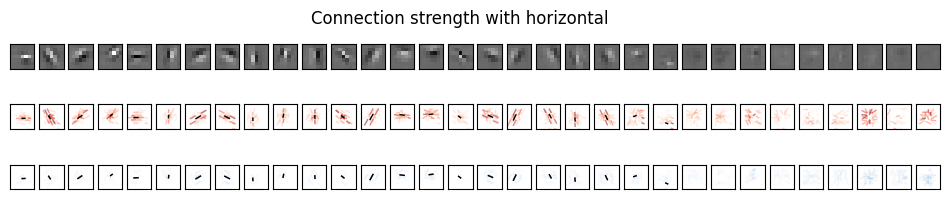

In [74]:
# connectivity_matrix = gram_all_flat_white
n_neurons=32
connectivity_matrix = horizontal_flat
neuron_indexs = norm_sort_idx[:n_neurons].tolist()
A = dictionary
needle_plot_generate_strength(connectivity_matrix, neuron_indexs, A, needle_properties, gnorm_flat, k = 50, name = "horizontal")

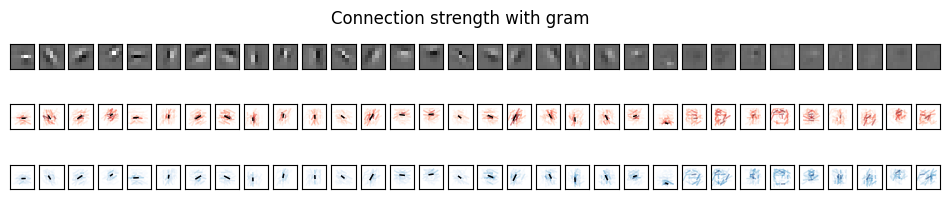

In [75]:
# connectivity_matrix = gram_all_flat_white
connectivity_matrix = gram_flat
# neuron_indexs = torch.arange(0,0+n_neurons)
neuron_indexs = norm_sort_idx[:n_neurons].tolist()
A = dictionary
needle_plot_generate_strength(connectivity_matrix, neuron_indexs, A, needle_properties, gnorm_flat, k = 50, name = "gram")